# Imports

In [10]:
import numpy as np
import import_ipynb
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
from mlxtend.plotting import plot_decision_regions
import pandas as pd

# Funções de Ativação

In [11]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [12]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

In [13]:
def mae(y, y_pred, derivative=False):
    
    if(derivative):
        return np.where(y_pred>y, 1, -1) / y.shape[0]
    
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative = False):
    
    if(derivative):
        return -(y - y_pred) / y.shape[0]
    
    return 0.5 * np.mean((y - y_pred)**2)

### Para Classificação Binaria

In [14]:
def binary_cross_entropy ( y, y_pred, derivative = False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) *y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1 - y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sidmoid(y_pred)
    
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    
    return -np.mean(y*np.log(y_sigmoid) + (1 - y)*np.log(1 - y_sigmoid))


### Para Classificação Multiclasse

In [15]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Neural Network

In [16]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.biases = np.random.randn(1, output_dim)
        self.activation = activation
        
        self._activ_inp, self._activ_out = None, None
        
        self._dweights, self._dbiases = None, None

class NeuralNetwork():
        def __init__(self, cost_func=mse, learning_rate=1e-3):
            self.layers = []
            self.cost_func = cost_func
            self.learning_rate = learning_rate
        
        def fit(self, x_train, y_train, epochs=100, verbose=10):
            for epoch in range( epochs + 1):
                y_pred = self.__feedforward(x_train)
                self.__backprop(y_train, y_pred)
                
                if(epoch % verbose == 0):
                    loss_train = self.cost_func(y_train, self.predict(x_train))
                    print(f"epoch: {epoch:=4}/{epochs:=4} loss_train: {loss_train:.8f}")
        
        def predict(self, x):
            return self.__feedforward(x)
            
        
        def __feedforward(self, x):
            self.layers[0].input = x
            
            for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
                y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
                current_layer._activ_inp = y
                current_layer._activ_out = next_layer.input = current_layer.activation(y)
            
            return self.layers[-1]._activ_out
                

        def __backprop(self, y, y_pred):
            last_delta = self.cost_func(y, y_pred, derivative=True)
            for layer in reversed(self.layers):
                dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta
                last_delta = np.dot(dactivation,layer.weights)
                layer._dweights = np.dot(dactivation.T, layer.input)
                layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
                
            for layer in reversed (self.layers):
                layer.weights = layer.weights - self.learning_rate * layer._dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases

## Exemplos

In [17]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])


input_dim, output_dim = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x,y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/   0 loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


In [18]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))



nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)

nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

for i, w, b in zip (range(3), [w1,w2,w3], [b1,b2,b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b
    
nn.fit(x,y, epochs = 300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/ 300 loss_train: 1.14054966
epoch:   30/ 300 loss_train: 0.59630022
epoch:   60/ 300 loss_train: 0.36031189
epoch:   90/ 300 loss_train: 0.24668884
epoch:  120/ 300 loss_train: 0.18386202
epoch:  150/ 300 loss_train: 0.14510157
epoch:  180/ 300 loss_train: 0.11918285
epoch:  210/ 300 loss_train: 0.10078511
epoch:  240/ 300 loss_train: 0.08712037
epoch:  270/ 300 loss_train: 0.07660623
epoch:  300/ 300 loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Regressão Linear Simples 

(100, 2)
(100, 1) (100, 1)


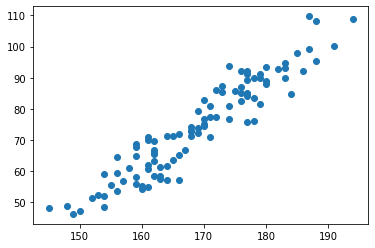

In [19]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


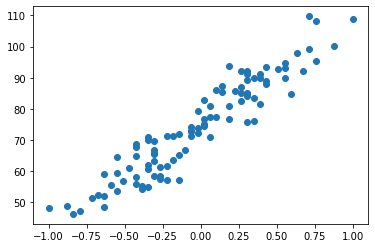

In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss_train: 2284.26640757
epoch:  100/1000 loss_train: 15.66186494
epoch:  200/1000 loss_train: 13.10165268
epoch:  300/1000 loss_train: 13.04284004
epoch:  400/1000 loss_train: 13.04148901
epoch:  500/1000 loss_train: 13.04145797
epoch:  600/1000 loss_train: 13.04145726
epoch:  700/1000 loss_train: 13.04145724
epoch:  800/1000 loss_train: 13.04145724
epoch:  900/1000 loss_train: 13.04145724
epoch: 1000/1000 loss_train: 13.04145724
[[33.60164744]]
[[74.99636286]]


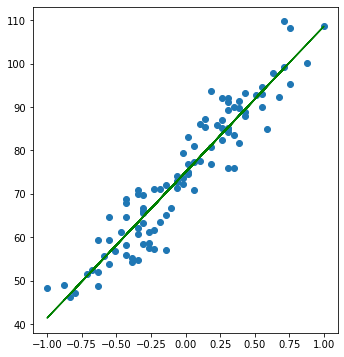

In [21]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x,y,epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [22]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))


[-1. -1. -1.] [1. 1. 1.]


In [24]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10171.08524669
epoch:  200/2000 loss_train: 6.42038297
epoch:  400/2000 loss_train: 3.89862104
epoch:  600/2000 loss_train: 3.20204116
epoch:  800/2000 loss_train: 2.98862060
epoch: 1000/2000 loss_train: 2.91561957
epoch: 1200/2000 loss_train: 2.88816217
epoch: 1400/2000 loss_train: 2.87710689
epoch: 1600/2000 loss_train: 2.87246193
epoch: 1800/2000 loss_train: 2.87046215
epoch: 2000/2000 loss_train: 2.86958971
[[ 8.92941714 13.98148948 26.17779775]]
[[150.63870632]]


### Regressão Quadrática

(100, 1) (100, 1)


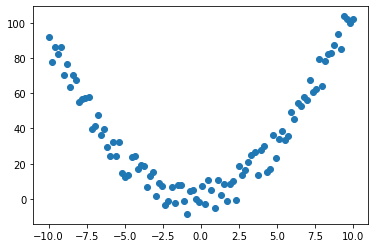

In [25]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 1054.88263061
epoch:  200/5000 loss_train: 488.75589127
epoch:  400/5000 loss_train: 411.01160111
epoch:  600/5000 loss_train: 192.02986335
epoch:  800/5000 loss_train: 93.41789648
epoch: 1000/5000 loss_train: 60.16026540
epoch: 1200/5000 loss_train: 45.59250835
epoch: 1400/5000 loss_train: 37.54209585
epoch: 1600/5000 loss_train: 32.45213537
epoch: 1800/5000 loss_train: 28.92858309
epoch: 2000/5000 loss_train: 26.33143377
epoch: 2200/5000 loss_train: 24.36511718
epoch: 2400/5000 loss_train: 22.54003966
epoch: 2600/5000 loss_train: 20.47771895
epoch: 2800/5000 loss_train: 19.39998821
epoch: 3000/5000 loss_train: 18.62646286
epoch: 3200/5000 loss_train: 18.03102582
epoch: 3400/5000 loss_train: 17.55516642
epoch: 3600/5000 loss_train: 17.16605915
epoch: 3800/5000 loss_train: 16.84234664
epoch: 4000/5000 loss_train: 16.56909748
epoch: 4200/5000 loss_train: 16.33572127
epoch: 4400/5000 loss_train: 16.13477871
epoch: 4600/5000 loss_train: 15.96093025
epoch: 4800

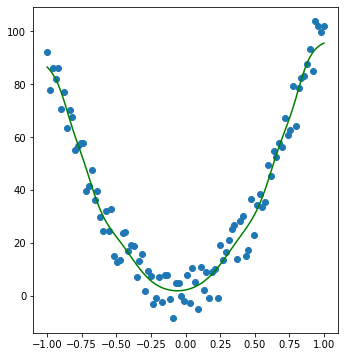

In [27]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func = mse, learning_rate= 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=5000, verbose=200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cubica

(100, 1) (100, 1)


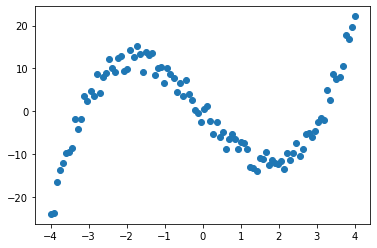

In [28]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [29]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 53.79961410
epoch:  300/3000 loss_train: 5.23484989
epoch:  600/3000 loss_train: 2.78238455
epoch:  900/3000 loss_train: 2.56352665
epoch: 1200/3000 loss_train: 1.74758446
epoch: 1500/3000 loss_train: 1.64346739
epoch: 1800/3000 loss_train: 1.84180716
epoch: 2100/3000 loss_train: 1.62050935
epoch: 2400/3000 loss_train: 1.89345833
epoch: 2700/3000 loss_train: 1.64140682
epoch: 3000/3000 loss_train: 1.63805432


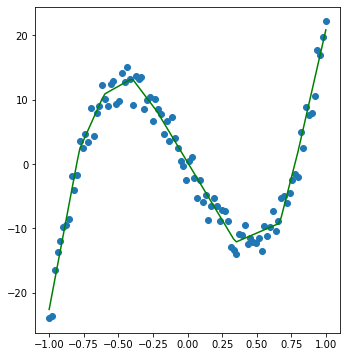

In [30]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

epoch:    0/3000 loss_train: 53.76558848
epoch:  300/3000 loss_train: 19.95242131
epoch:  600/3000 loss_train: 10.49074207
epoch:  900/3000 loss_train: 4.47569886
epoch: 1200/3000 loss_train: 3.40082306
epoch: 1500/3000 loss_train: 2.84714159
epoch: 1800/3000 loss_train: 2.49763553
epoch: 2100/3000 loss_train: 2.26184039
epoch: 2400/3000 loss_train: 2.09504418
epoch: 2700/3000 loss_train: 1.97237886
epoch: 3000/3000 loss_train: 1.87912598


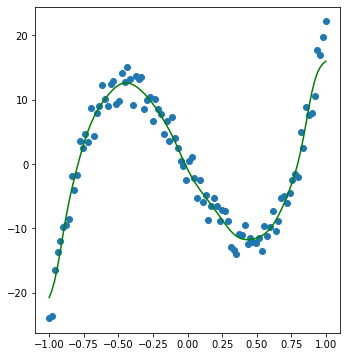

In [31]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=12, activation=tanh))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=tanh))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=tanh))
nn.layers.append(Layer(input_dim=12, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


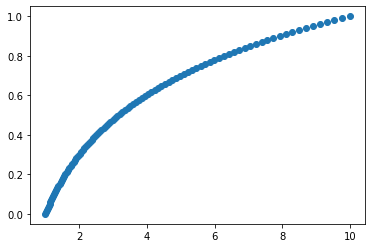

In [32]:
x, y = make_log10(n_samples=100, x_min=1, x_max=10, noise=0)

print(x.shape, y.shape)
plt.scatter(x, y)

In [33]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 0.08095304
epoch:  300/3000 loss_train: 0.00271514
epoch:  600/3000 loss_train: 0.00179200
epoch:  900/3000 loss_train: 0.00122926
epoch: 1200/3000 loss_train: 0.00088368
epoch: 1500/3000 loss_train: 0.00067054
epoch: 1800/3000 loss_train: 0.00053848
epoch: 2100/3000 loss_train: 0.00045621
epoch: 2400/3000 loss_train: 0.00040456
epoch: 2700/3000 loss_train: 0.00037176
epoch: 3000/3000 loss_train: 0.00035058


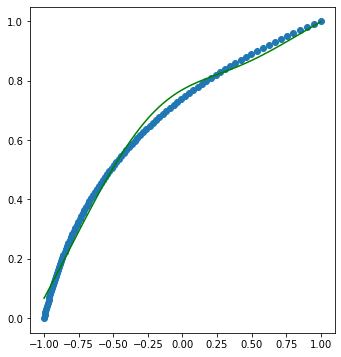

In [34]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
# nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=3000, verbose=300)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


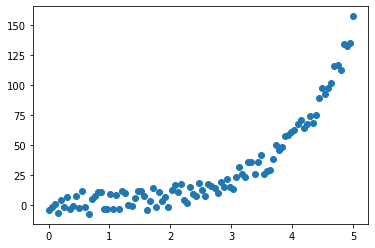

In [35]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [36]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 1315.75077516
epoch:  300/3000 loss_train: 23.99123985
epoch:  600/3000 loss_train: 19.10134013
epoch:  900/3000 loss_train: 18.71898897
epoch: 1200/3000 loss_train: 18.37506049
epoch: 1500/3000 loss_train: 18.04051745
epoch: 1800/3000 loss_train: 17.72466805
epoch: 2100/3000 loss_train: 17.43760439
epoch: 2400/3000 loss_train: 17.17993257
epoch: 2700/3000 loss_train: 16.95816563
epoch: 3000/3000 loss_train: 16.76733117


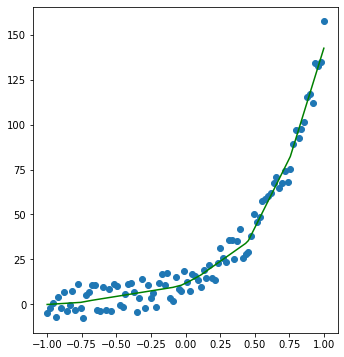

In [37]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=12, activation=relu))
nn.layers.append(Layer(input_dim=12, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


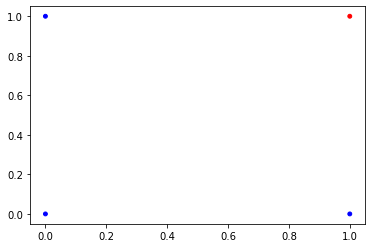

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.58756930
epoch:  100/1000 loss_train: 0.13341824
epoch:  200/1000 loss_train: 0.07809471
epoch:  300/1000 loss_train: 0.05475805
epoch:  400/1000 loss_train: 0.04199253
epoch:  500/1000 loss_train: 0.03398222
epoch:  600/1000 loss_train: 0.02850342
epoch:  700/1000 loss_train: 0.02452708
epoch:  800/1000 loss_train: 0.02151329
epoch:  900/1000 loss_train: 0.01915221
epoch: 1000/1000 loss_train: 0.01725364
Predições:
[[1.21011794e-05]
 [2.00532148e-02]
 [2.00532338e-02]
 [9.71913531e-01]]
Acurácia: 100.00%


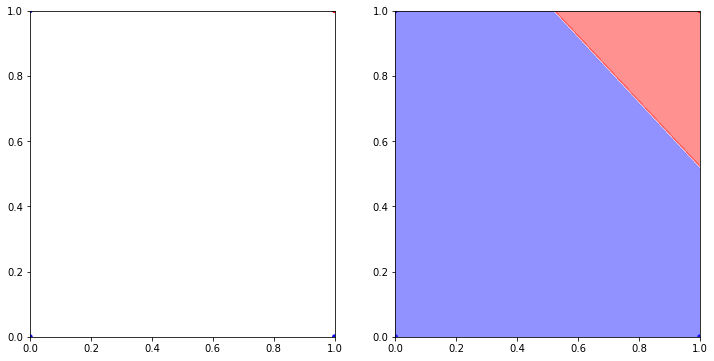

In [39]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation = sigmoid))

nn.fit(x,y, epochs=1000, verbose= 100)


y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5 , cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


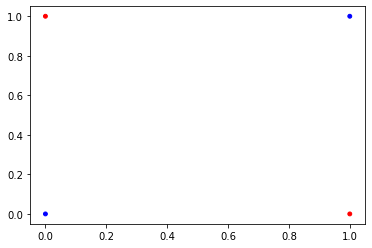

In [69]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/3000 loss_train: 0.70392330
epoch:  300/3000 loss_train: 0.08324949
epoch:  600/3000 loss_train: 0.02470105
epoch:  900/3000 loss_train: 0.01409170
epoch: 1200/3000 loss_train: 0.00979293
epoch: 1500/3000 loss_train: 0.00748392
epoch: 1800/3000 loss_train: 0.00604778
epoch: 2100/3000 loss_train: 0.00507002
epoch: 2400/3000 loss_train: 0.00436217
epoch: 2700/3000 loss_train: 0.00382641
epoch: 3000/3000 loss_train: 0.00340699
Predições:
[[0.00327973]
 [0.995517  ]
 [0.99698378]
 [0.00282499]]
Acurácia: 100.00%


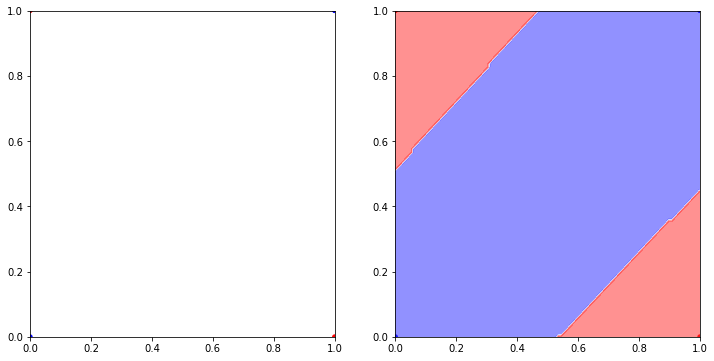

In [74]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.fit(x,y, epochs=3000, verbose=300)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, threshold=0.5, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


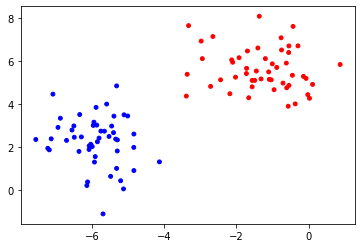

In [43]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/3000 loss_train: 3.32003654
epoch:  300/3000 loss_train: 0.00263278
epoch:  600/3000 loss_train: 0.00189542
epoch:  900/3000 loss_train: 0.00152209
epoch: 1200/3000 loss_train: 0.00128704
epoch: 1500/3000 loss_train: 0.00112210
epoch: 1800/3000 loss_train: 0.00099851
epoch: 2100/3000 loss_train: 0.00090172
epoch: 2400/3000 loss_train: 0.00082347
epoch: 2700/3000 loss_train: 0.00075866
epoch: 3000/3000 loss_train: 0.00070395
Acurácia: 100.00%


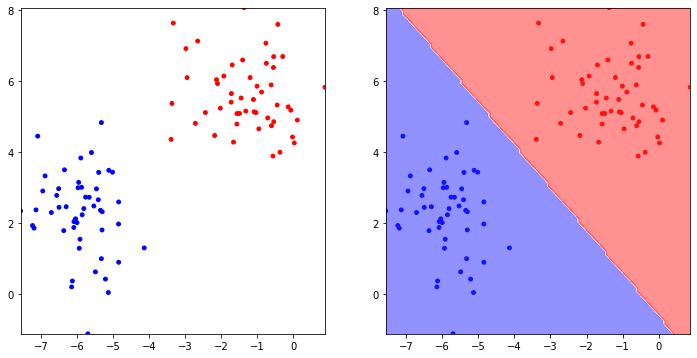

In [44]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim = output_dim, activation= sigmoid))

nn.fit(x,y, epochs=3000, verbose= 300)


y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


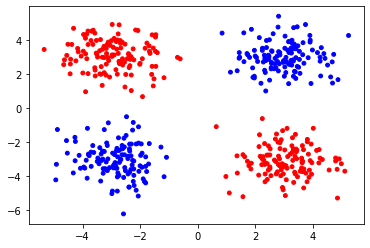

In [45]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/3000 loss_train: 0.54268445
epoch:  300/3000 loss_train: 0.07348994
epoch:  600/3000 loss_train: 0.03233379
epoch:  900/3000 loss_train: 0.02031744
epoch: 1200/3000 loss_train: 0.01457406
epoch: 1500/3000 loss_train: 0.01124605
epoch: 1800/3000 loss_train: 0.00908767
epoch: 2100/3000 loss_train: 0.00758932
epoch: 2400/3000 loss_train: 0.00648280
epoch: 2700/3000 loss_train: 0.00563660
epoch: 3000/3000 loss_train: 0.00497221
Acurácia: 100.00%


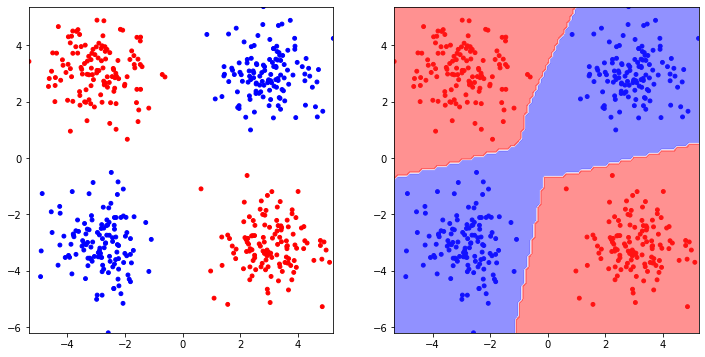

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))

nn.fit(x,y, epochs=3000, verbose= 300)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


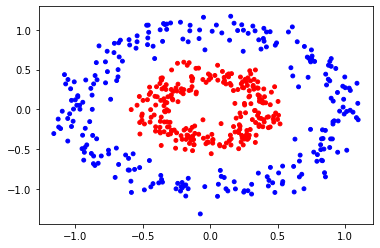

In [47]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/3000 loss_train: 1.77966701
epoch:  300/3000 loss_train: 0.18062711
epoch:  600/3000 loss_train: 0.06808597
epoch:  900/3000 loss_train: 0.04043373
epoch: 1200/3000 loss_train: 0.02805702
epoch: 1500/3000 loss_train: 0.02148961
epoch: 1800/3000 loss_train: 0.01729396
epoch: 2100/3000 loss_train: 0.01441369
epoch: 2400/3000 loss_train: 0.01224729
epoch: 2700/3000 loss_train: 0.01066437
epoch: 3000/3000 loss_train: 0.00943789
Acurácia: 100.00%


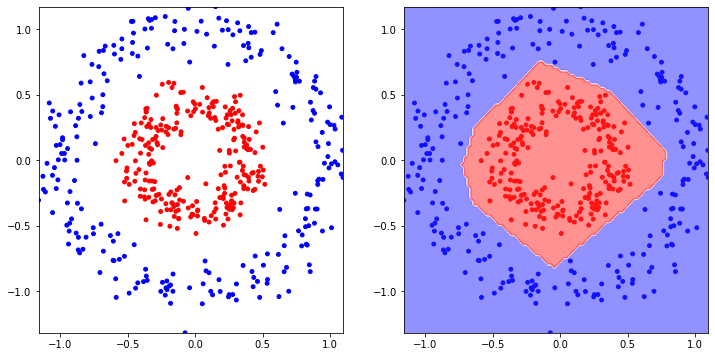

In [48]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=6, activation= relu))
nn.layers.append(Layer(input_dim=6, output_dim=6, activation= relu))
nn.layers.append(Layer(input_dim=6, output_dim=output_dim, activation= sigmoid))

nn.fit(x,y, epochs=3000, verbose=300)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


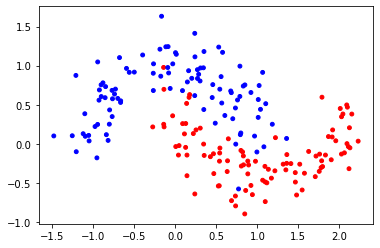

In [49]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss_train: 0.84280891
epoch:  300/2000 loss_train: 0.30608312
epoch:  600/2000 loss_train: 0.30264663
epoch:  900/2000 loss_train: 0.29869420
epoch: 1200/2000 loss_train: 0.29116879
epoch: 1500/2000 loss_train: 0.27023040
epoch: 1800/2000 loss_train: 0.23573136
Acurácia: 92.50%


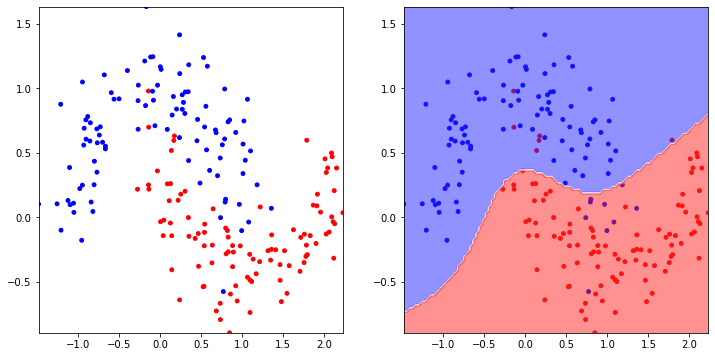

In [50]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation= tanh))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation= sigmoid))
# nn.layers.append(Layer(input_dim=6, output_dim=output_dim, activation= sigmoid))


## a relu da uma acuracia melhor
nn.fit(x,y, epochs=2000, verbose=300)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


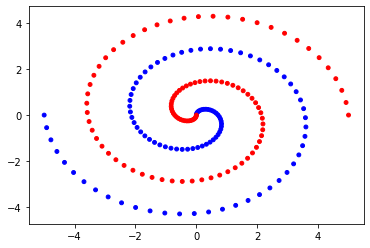

In [51]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/10000 loss_train: 1.41895784
epoch: 1000/10000 loss_train: 0.20155940
epoch: 2000/10000 loss_train: 0.09361415
epoch: 3000/10000 loss_train: 0.05182179
epoch: 4000/10000 loss_train: 0.03204286
epoch: 5000/10000 loss_train: 0.02355079
epoch: 6000/10000 loss_train: 0.01899875
epoch: 7000/10000 loss_train: 0.01643319
epoch: 8000/10000 loss_train: 0.01472843
epoch: 9000/10000 loss_train: 0.01351230
epoch: 10000/10000 loss_train: 0.01260357
Acurácia: 99.50%


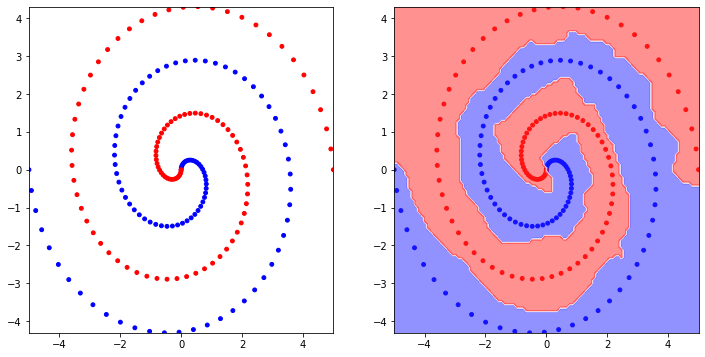

In [52]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 0.1)
nn.layers.append(Layer(input_dim= input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim= 20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim= 20, output_dim=output_dim, activation=sigmoid))

nn.fit(x,y, epochs= 10000, verbose= 1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

epoch:    0/10000 loss_train: 4.65463129


/tmp/ipykernel_25422/1205617835.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) *y.shape[0])
/tmp/ipykernel_25422/532939424.py:45: RuntimeWarning: invalid value encountered in multiply
  dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta


epoch: 1000/10000 loss_train: nan
epoch: 2000/10000 loss_train: nan
epoch: 3000/10000 loss_train: nan
epoch: 4000/10000 loss_train: nan
epoch: 5000/10000 loss_train: nan
epoch: 6000/10000 loss_train: nan
epoch: 7000/10000 loss_train: nan
epoch: 8000/10000 loss_train: nan
epoch: 9000/10000 loss_train: nan
epoch: 10000/10000 loss_train: nan
Acurácia: 50.00%


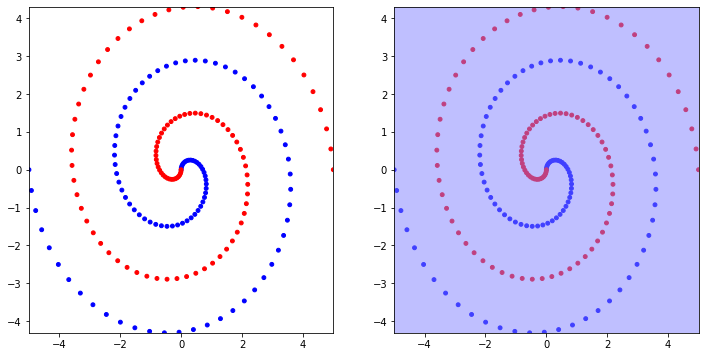

In [53]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate= 0.1)
nn.layers.append(Layer(input_dim= input_dim, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim= 20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim= 20, output_dim=output_dim, activation=sigmoid))

nn.fit(x,y, epochs= 10000, verbose= 1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


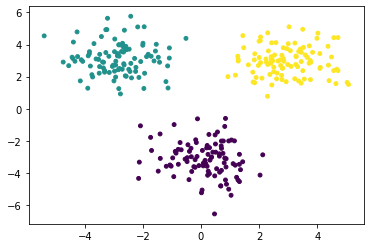

In [54]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [55]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 2.95337578
epoch:  100/1000 loss_train: 0.56291484
epoch:  200/1000 loss_train: 0.51068286
epoch:  300/1000 loss_train: 0.49432800
epoch:  400/1000 loss_train: 0.48612942
epoch:  500/1000 loss_train: 0.48092520
epoch:  600/1000 loss_train: 0.47727588
epoch:  700/1000 loss_train: 0.47452432
epoch:  800/1000 loss_train: 0.47235997
epoch:  900/1000 loss_train: 0.47033725
epoch: 1000/1000 loss_train: 0.46865036
Acurácia: 68.67%


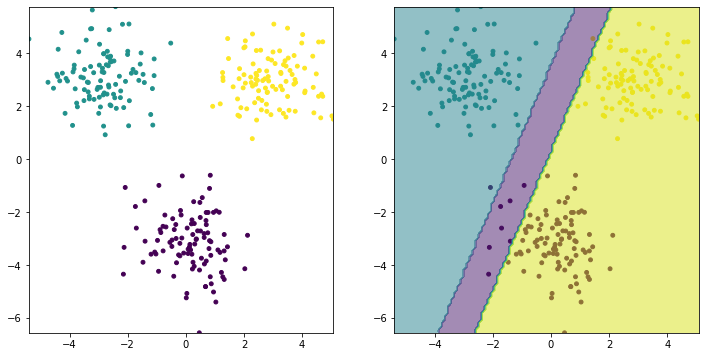

In [56]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn= NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs= 1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


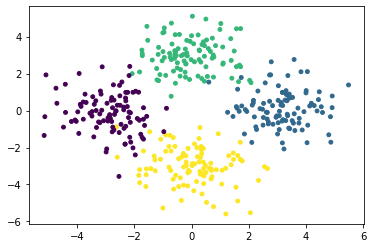

In [57]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [58]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 5.41909260
epoch:  100/1000 loss_train: 0.13183946
epoch:  200/1000 loss_train: 0.10030928
epoch:  300/1000 loss_train: 0.09078971
epoch:  400/1000 loss_train: 0.08624911
epoch:  500/1000 loss_train: 0.08360312
epoch:  600/1000 loss_train: 0.08183751
epoch:  700/1000 loss_train: 0.08061889
epoch:  800/1000 loss_train: 0.07969317
epoch:  900/1000 loss_train: 0.07895866
epoch: 1000/1000 loss_train: 0.07835361
Acurácia: 96.75%


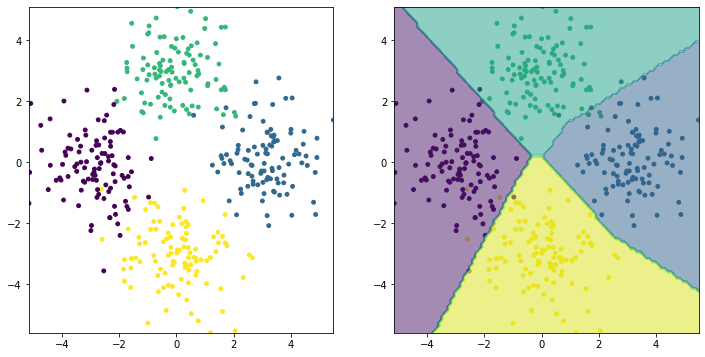

In [59]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn= NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs= 1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


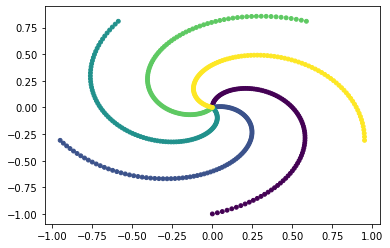

In [60]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [61]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/10000 loss_train: 3.05717331
epoch: 1000/10000 loss_train: 0.27235970
epoch: 2000/10000 loss_train: 0.14125022
epoch: 3000/10000 loss_train: 0.08743865
epoch: 4000/10000 loss_train: 0.06336749
epoch: 5000/10000 loss_train: 0.05149437
epoch: 6000/10000 loss_train: 0.04450421
epoch: 7000/10000 loss_train: 0.03996940
epoch: 8000/10000 loss_train: 0.03686057
epoch: 9000/10000 loss_train: 0.03443584
epoch: 10000/10000 loss_train: 0.03248788
Acurácia: 99.20%


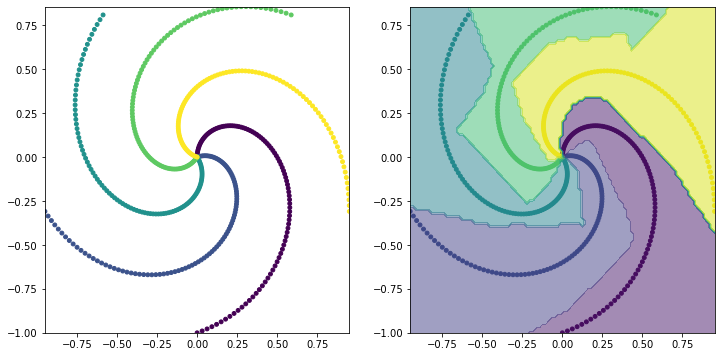

In [62]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose= 1000)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


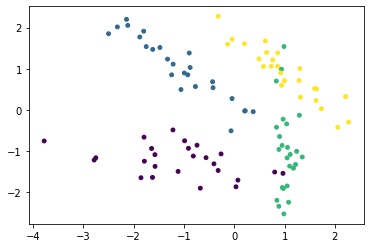

In [63]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [64]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/10000 loss_train: 2.74798278
epoch: 1000/10000 loss_train: 0.16999322
epoch: 2000/10000 loss_train: 0.13976878
epoch: 3000/10000 loss_train: 0.11206360
epoch: 4000/10000 loss_train: 0.09421167
epoch: 5000/10000 loss_train: 0.08296416
epoch: 6000/10000 loss_train: 0.07541785
epoch: 7000/10000 loss_train: 0.07045120
epoch: 8000/10000 loss_train: 0.06706661
epoch: 9000/10000 loss_train: 0.06452437
epoch: 10000/10000 loss_train: 0.06266861
Acurácia: 98.00%


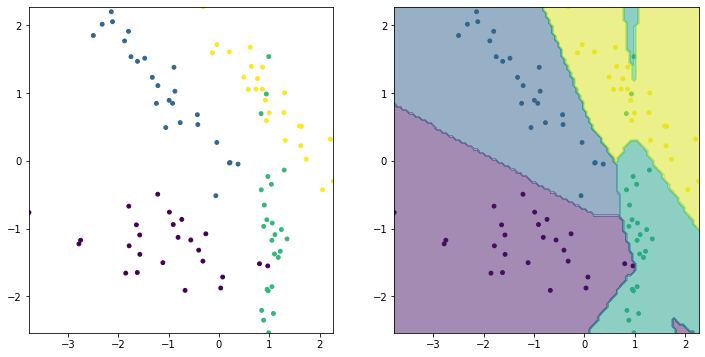

In [65]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose= 1000)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


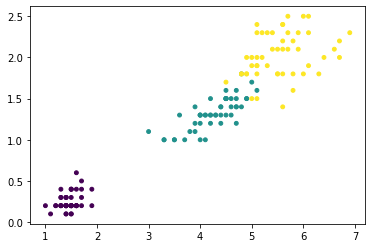

In [66]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [67]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/10000 loss_train: 2.31342310
epoch: 1000/10000 loss_train: 0.09834311
epoch: 2000/10000 loss_train: 0.07796533
epoch: 3000/10000 loss_train: 0.07266785
epoch: 4000/10000 loss_train: 0.07098591
epoch: 5000/10000 loss_train: 0.06959238
epoch: 6000/10000 loss_train: 0.07057312
epoch: 7000/10000 loss_train: 0.06916331
epoch: 8000/10000 loss_train: 0.06886798
epoch: 9000/10000 loss_train: 0.06874283
epoch: 10000/10000 loss_train: 0.06868121
Acurácia: 96.00%


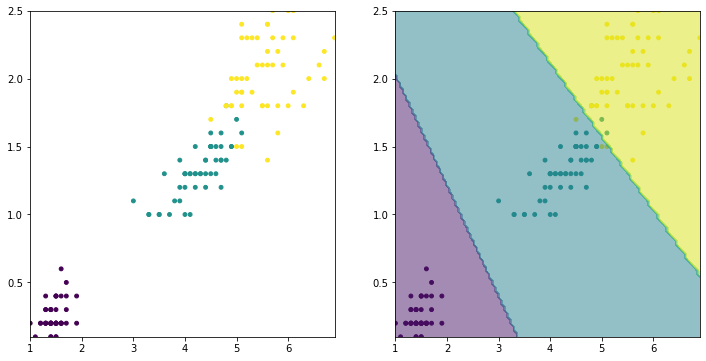

In [68]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate= 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)